In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
from scipy import stats

import plotly.io as pio
pio.renderers.default = "png"
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

from sklearn.model_selection import train_test_split

from statsmodels import api as sm

from functions import df_engineered

In [2]:
df = pd.read_csv('data/Ames_Housing_Price_Data.csv', index_col=0).iloc[:,1:]
print('df shape:', df.shape)

data = df_engineered(df)

df shape: (2580, 80)


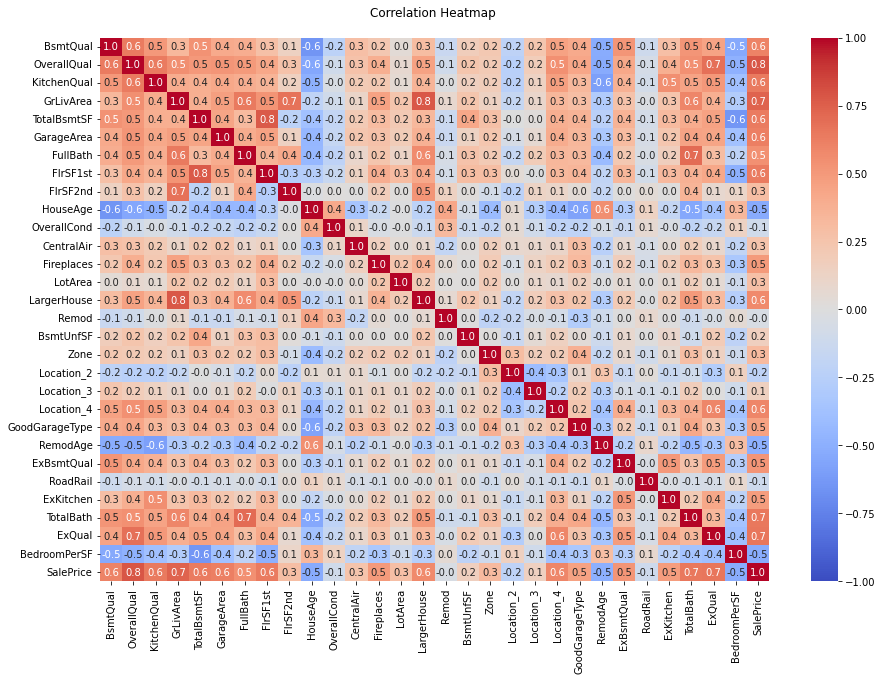

In [3]:
feature_selection = ['BsmtQual' , 'OverallQual' , 'KitchenQual' ,
                    'GrLivArea' , 'TotalBsmtSF'  , 'GarageArea' , 'FullBath' , 'FlrSF1st' , 'FlrSF2nd',
                    'HouseAge'  , 'OverallCond' , 'CentralAir',
                    'Fireplaces' , 'LotArea' , 'LargerHouse' , 'Remod',
                    'BsmtUnfSF' , 'Zone' , 'Location_2', 'Location_3' , 'Location_4' , 'GoodGarageType',
                    'RemodAge' , 'ExBsmtQual' , 'RoadRail', 'ExKitchen' , 'TotalBath', 
                    'ExQual', 'BedroomPerSF']

plt.figure(figsize=(15, 10))

corr_mat = data[feature_selection + ['SalePrice']].corr()

sns.heatmap(corr_mat,
            annot=True,
            fmt='.1f',
            vmin=-1,
            vmax=1,
            cmap='coolwarm'
            )
title = plt.title('Correlation Heatmap \n')

In [4]:
skewness = data[feature_selection].skew().sort_values(ascending=False)
print(skewness[abs(skewness) > 0.75])
skewed_cols = list(skewness[abs(skewness) > 0.75].index)

data['LotArea'] = np.log(data['LotArea'])
#data['FlrSF2nd'] = np.log(data['GrLivArea'])

LotArea         13.647537
ExKitchen        4.212534
RoadRail         3.690437
ExBsmtQual       3.571738
ExQual           2.079905
Location_4       1.821239
Location_3       1.405190
FlrSF1st         1.045575
BsmtUnfSF        0.981279
GrLivArea        0.943880
FlrSF2nd         0.804334
BedroomPerSF     0.767331
Zone            -1.733407
CentralAir      -3.705920
dtype: float64


In [5]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='SalePrice'), data[['SalePrice']], test_size=0.30, random_state=42)

# Model

### Standardization

In [6]:
scaler = StandardScaler()

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = np.log(y_train.reset_index(drop=True)['SalePrice'])
y_test = np.log(y_test.reset_index(drop=True)['SalePrice'])

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[feature_selection]), columns=X_train[feature_selection].columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[feature_selection]), columns=X_test[feature_selection].columns)

In [7]:
X_train

,GrLivArea,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,FlrSF1st,FlrSF2nd,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,HouseAge,RemodAge,TotalSF,TotalBath,TotalFullBath,TotalHalfBath,RoadRail,BedroomPerSF,GoodGarageType,Zone,CulDSac,Exterior1st_top,TwoStory,ExQual,LargerHouse,Remod,ExBsmtQual,HasFireplace,ExKitchen,ExterQual,BsmtQual,KitchenQual,ExterCond,Location_2,Location_3,Location_4,Foundation_CBlock,Foundation_PConc,Foundation_Slab,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE
0,1050,20,RL,65.0,9.048997,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Story,5,7,1971,1971,Gable,CompShg,Plywood,Plywood,BrkFace,178.0,TA,No,ALQ,500.0,Unf,0.0,543.0,1043.0,GasA,Ex,1,SBrkr,1050,0,0,1.0,0.0,1,1,3,1,6,Typ,0,None,Attchd,1971.0,Unf,1.0,336.0,TA,TA,Y,0,0,0,0,0,0,0,None,None,0,7,2009,WD,Normal,38,38,2093.0,2.5,2.0,1.0,0,0.001433,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,2.0,2.0,1,0,0,1,0,0,0,0,0,0
1,1252,160,FV,24.0,7.677864,Pave,Pave,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,2Story,7,5,1999,2000,Gable,CompShg,MetalSd,MetalSd,BrkFace,212.0,TA,No,BLQ,510.0,Unf,0.0,90.0,600.0,GasA,Ex,1,SBrkr,624,628,0,1.0,0.0,2,1,2,1,4,Typ,0,None,Detchd,1999.0,Unf,2.0,462.0,TA,TA,Y,0,48,0,0,0,0,0,None,None,0,3,2008,WD,Normal,9,8,1852.0,3.5,3.0,1.0,0,0.001080,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,3.0,3.0,2.0,0,0,1,0,1,0,0,0,1,0
2,1344,50,RM,65.0,8.738735,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,Norm,Norm,1.5Fin,5,4,1936,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,No,Unf,0.0,Unf,0.0,896.0,896.0,GasA,Gd,1,FuseA,896,448,0,0.0,0.0,1,0,3,1,7,Typ,0,None,Detchd,1936.0,Unf,1.0,240.0,Fa,TA,Y,200,114,0,0,0,0,0,None,None,0,4,2006,WD,Normal,70,56,2240.0,1.0,1.0,0.0,0,0.001339,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,2.0,2.0,0,0,0,0,0,0,0,0,0,0
3,1228,20,RL,47.5,9.052985,Pave,None,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,Norm,Norm,1Story,5,6,1966,2006,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,No,Unf,0.0,Unf,0.0,1228.0,1228.0,GasA,Gd,1,SBrkr,1228,0,0,0.0,0.0,1,1,3,1,6,Typ,0,None,Attchd,1966.0,Unf,1.0,271.0,TA,TA,Y,0,65,0,0,0,0,0,MnPrv,None,0,6,2008,WD,Normal,42,2,2456.0,1.5,1.0,1.0,0,0.001221,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,3.0,2.0,1,0,0,1,0,0,0,0,0,0
4,2683,60,RL,65.0,9.127502,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,NoRidge,Norm,Norm,2Story,6,5,1990,1991,Hip,CompShg,HdBoard,HdBoard,BrkFace,304.0,TA,No,ALQ,704.0,Unf,0.0,226.0,930.0,GasA,Ex,1,SBrkr,1364,1319,0,1.0,0.0,2,1,4,1,9,Typ,2,Gd,Attchd,1990.0,RFn,2.0,473.0,TA,TA,Y,237,251,0,0,196,0,0,None,None,0,6,2008,WD,Normal,18,17,3613.0,3.5,3.0,1.0,0,0.001107,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,2.0,3.0,3.0,2.0,0,0,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673,1717,50,RL,80.0,9.425452,Pave,None,Reg,HLS,AllPub,Inside,Mod,Crawfor,Norm,Norm,1.5Fin,5,6,1940,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,Mn,BLQ,602.0,Unf,0.0,299.0,901.0,GasA,TA,1,SBrkr,1125,592,0,0.0,0.0,1,1,2,1,7,Typ,1,Gd,Attchd,1940.0,Unf

In [8]:
X_train_scaled

,BsmtQual,OverallQual,KitchenQual,GrLivArea,TotalBsmtSF,GarageArea,FullBath,FlrSF1st,FlrSF2nd,HouseAge,OverallCond,CentralAir,Fireplaces,LotArea,LargerHouse,Remod,BsmtUnfSF,Zone,Location_2,Location_3,Location_4,GoodGarageType,RemodAge,ExBsmtQual,RoadRail,ExKitchen,TotalBath,ExQual,BedroomPerSF
0,0.684125,-0.782154,-0.746971,-0.894954,0.031524,-0.649206,-0.995955,-0.237496,-0.793861,0.005946,1.229185,0.247697,-0.955359,-0.063211,-0.913170,-0.909883,0.038566,0.453277,1.281608,-0.517080,-0.450408,0.732550,0.691302,-0.26615,-0.251737,-0.236664,0.401109,-0.402554,0.649492
1,0.684125,0.733382,0.825698,-0.470773,-1.060798,-0.016987,0.852731,-1.420700,0.688593,-0.978152,-0.576130,0.247697,-0.955359,-2.771676,-0.913170,1.099043,-1.051298,0.453277,-0.780270,-0.517080,2.220209,-1.365094,-0.802459,-0.26615,-0.251737,-0.236664,1.722133,-0.402554,-0.302099
2,0.684125,-0.782154,-0.746971,-0.277581,-0.330940,-1.130896,-0.995955,-0.665227,0.263686,1.091846,-1.478788,0.247697,-0.955359,-0.676086,-0.913170,1.099043,0.887842,-2.206158,-0.780270,-0.517080,-0.450408,-1.365094,1.587559,-0.26615,-0.251737,-0.236664,-1.580426,-0.402554,0.396235
3,-0.608624,-0.782154,0.825698,-0.521171,0.487686,-0.975350,-0.995955,0.256895,-0.793861,0.141683,0.326528,0.247697,-0.955359,-0.055335,-0.913170,1.099043,1.686594,0.453277,1.281608,-0.517080,-0.450408,0.732550,-1.101211,-0.26615,-0.251737,-0.236664,-0.919914,-0.402554,0.079104
4,0.684125,-0.024386,0.825698,2.534198,-0.247104,0.038206,0.852731,0.634632,2.319765,-0.672742,-0.576130,0.247697,2.178741,0.091863,1.095086,1.099043,-0.724098,0.453277,-0.780270,-0.517080,2.220209,0.732550,-0.354331,-0.26615,-0.251737,-0.236664,1.722133,-0.402554,-0.228867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1673,0.684125,-0.782154,-0.746971,0.505685,-0.318611,-0.277903,-0.995955,-0.029185,0.603612,0.956109,0.326528,0.247697,0.611691,0.680417,1.095086,1.099043,-0.548469,0.453277,-0.780270,1.933937,-0.450408,0.732550,1.587559,-0.26615,-0.251737,-0.236664,-0.919914,-0.402554,-1.152822
1674,-0.608624,-0.024386,-0.746971,1.118859,-0.883265,1.653876,0.852731,0.559640,0.792459,1.363322,1.229185,0.247697,2.178741,1.619759,1.095086,1.099043,0.348924,0.453277,-0.780270,-0.517080,-0.450408,-1.365094,1.587559,-0.26615,-0.251737,-0.236664,-0.259402,-0.402554,0.807351
1675,-0.608624,-0.024386,-0.746971,-0.451874,0.569055,-0.162498,-0.995955,0.348552,-0.793861,0.413158,0.326528,0.247697,0.611691,0.073538,-0.913170,-0.909883,0.173295,0.453277,1.281608,-0.517080,-0.450408,0.732550,1.288807,-0.26615,-0.251737,-0.236664,-0.259402,-0.402554,-0.006962
1676,-0.608624,-0.782154,-0.746971,-0.699663,0.278098,-0.789699,-0.995955,0.020810,-0.793861,0.447093,-0.576130,0.247697,-0.955359,-0.172981,-0.913170,-0.909883,-0.967092,0.453277,1.281608,-0.517080,-0.450408,0.732550,1.338599,-0.26615,-0.251737,-0.236664,-0.259402,-0.402554,0.323675


## Linear Regression

In [9]:
ols = LinearRegression()
ols.fit(X_train_scaled, y_train)

kf = KFold(n_splits=5, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(ols, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(ols, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(ols, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.9276 0.9279 0.9336 0.933  0.9492]
Mean shuffled cross validation score: 0.9343
RMSE Shuffled cross validation score: [0.0947 0.0993 0.0903 0.0969 0.0826]
RMSE Mean shuffled cross validation score: 0.0928


In [10]:
test_score = ols.score(X_test_scaled, y_test)

print('Test score:', np.round(test_score, 4))

rms = mean_squared_error(y_test, ols.predict(X_test_scaled), squared=False)
print('RMSE Test score:', np.round(rms, 4))

Test score: 0.9327
RMSE Test score: 0.097


In [11]:
yhat_train = ols.predict(X_train_scaled)
yhat_test = ols.predict(X_test_scaled)

train_rmse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

16415.050405012156
16900.65194519879


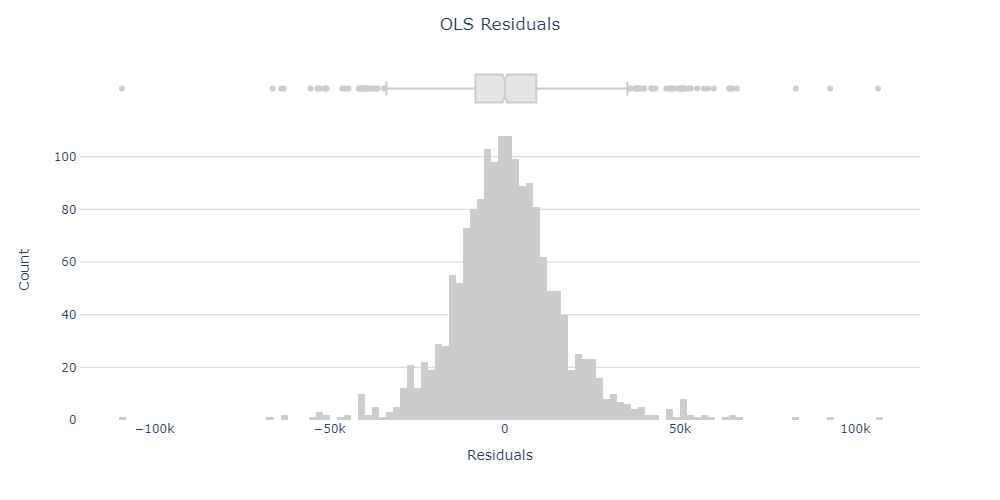

In [12]:
yhat = ols.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                pd.concat([X_train, np.exp(y_train)], axis=1), 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])

#Plot
fig = px.histogram(
                results, 
                x="residual",
                marginal="box",
                width=1000)

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
                title='OLS Residuals', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Residuals",
                row=1, col=1)

fig.show()

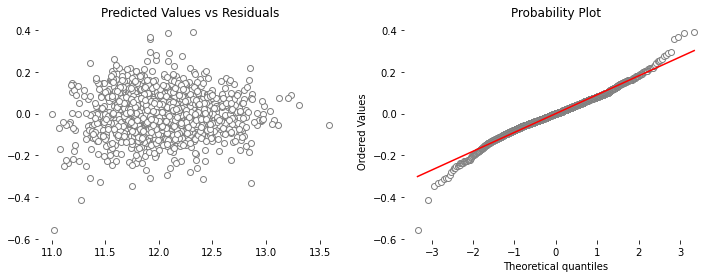

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)

ax[0].scatter(yhat, residuals, edgecolors='grey', color='white')
ax[0].title.set_text('Predicted Values vs Residuals')

stats.probplot(residuals, dist="norm", plot=plt)
ax[1].get_lines()[0].set_markeredgecolor('grey')
ax[1].get_lines()[0].set_markerfacecolor('white')

plt.show()

In [14]:
res = stats.shapiro(residuals)
res.statistic

0.980633020401001

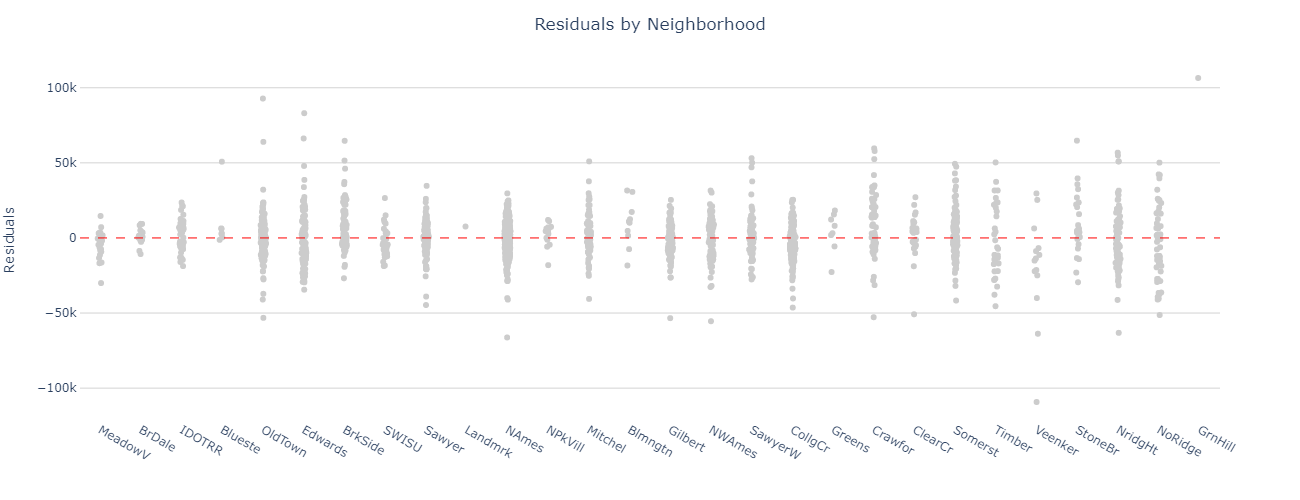

In [15]:
order = results.groupby('Neighborhood').SalePrice.median().sort_values().index

fig = px.strip(
            results, 
            x='Neighborhood', 
            y='residual',
            category_orders={'Neighborhood':order},
            width=1300)  

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
            title='Residuals by Neighborhood', title_x=0.5,
            showlegend=False,
            plot_bgcolor='white')

fig.update_yaxes(
            showline=True,
            gridcolor='lightgray',
            title="Residuals")
            
fig.update_xaxes(
            title=None)

fig.add_hline(y=0, line_width=1, line_dash="dash", line_color="red")

fig.show()

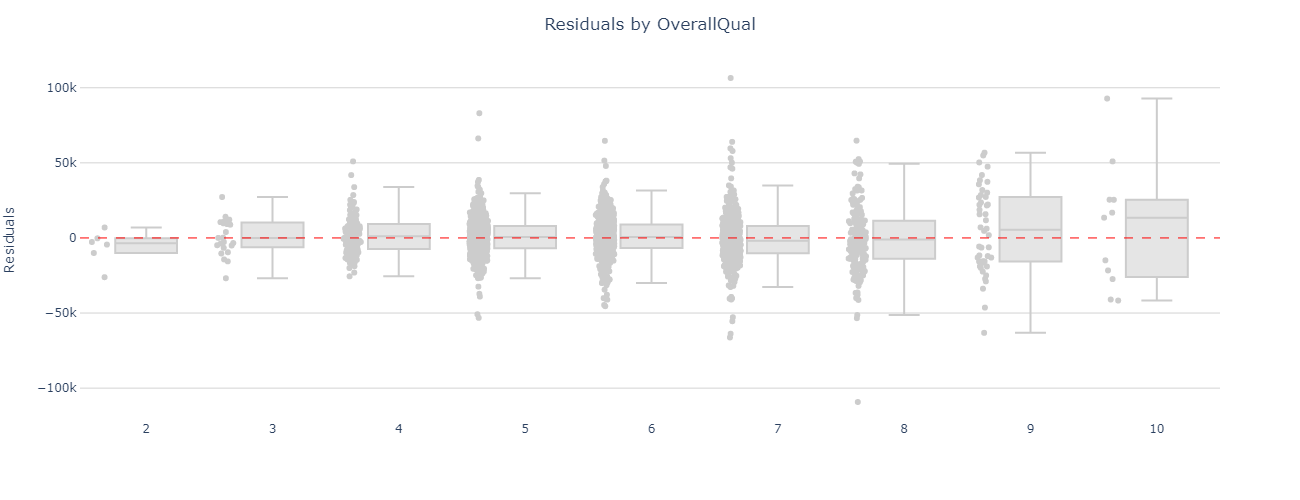

In [16]:
order = results.groupby('OverallQual').SalePrice.median().sort_values().index

fig = px.box(
            results, 
            x='OverallQual', 
            y='residual',
            category_orders={'OverallQual':order},
            points="all",
            width=1300)  

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
            title='Residuals by OverallQual', title_x=0.5,
            showlegend=False,
            plot_bgcolor='white')

fig.update_yaxes(
            showline=True,
            gridcolor='lightgray',
            title="Residuals")
            
fig.update_xaxes(
            title=None)

fig.add_hline(y=0, line_width=1, line_dash="dash", line_color="red")

fig.show()

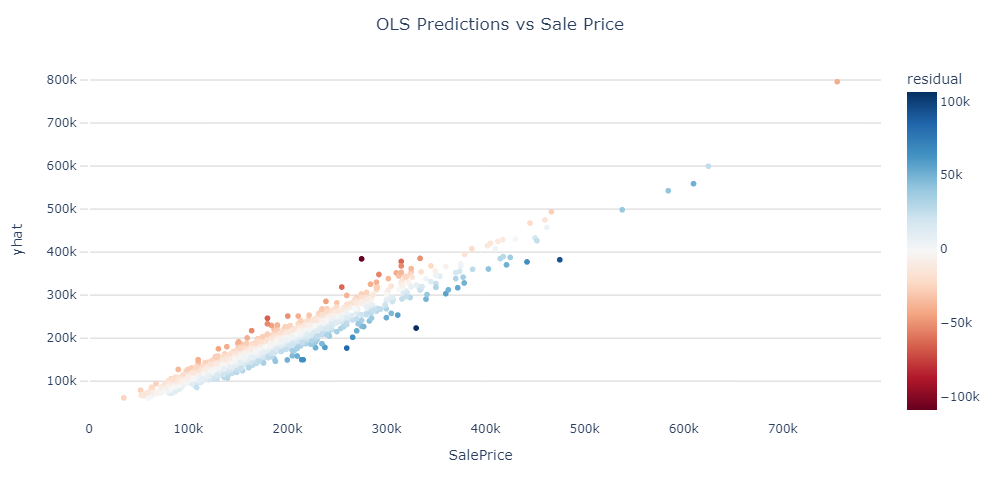

In [17]:
fig = px.scatter(
            results, 
            x='SalePrice', 
            y='yhat',
            color='residual',
            color_continuous_scale='RdBu',
            width=1000)

fig.update_layout(
            title='OLS Predictions vs Sale Price', title_x=0.5,
            showlegend=False,
            plot_bgcolor='white')
            
fig.update_yaxes(
            showline=True,
            gridcolor='lightgray')
            
fig.show()

## Lasso

In [20]:
lasso = LassoCV(cv=5)
lasso.fit(X_train_scaled, y_train)

best_alpha = lasso.alpha_
print('Best alpha:', best_alpha)

# Predict on the test set
y_pred = lasso.predict(X_test_scaled)

# Calculate RMSE
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse_lasso)


Best alpha: 0.0002964851030638201
RMSE: 0.09715776725144173


In [21]:
kf = KFold(n_splits=2, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(lasso, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(lasso, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(lasso, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.9303 0.938 ]
Mean shuffled cross validation score: 0.9342
RMSE Shuffled cross validation score: [0.0955 0.0907]
RMSE Mean shuffled cross validation score: 0.0931


In [22]:
yhat_train = lasso.predict(X_train_scaled)
yhat_test = lasso.predict(X_test_scaled)

train_rmse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

16390.441206127747
16922.139556400016


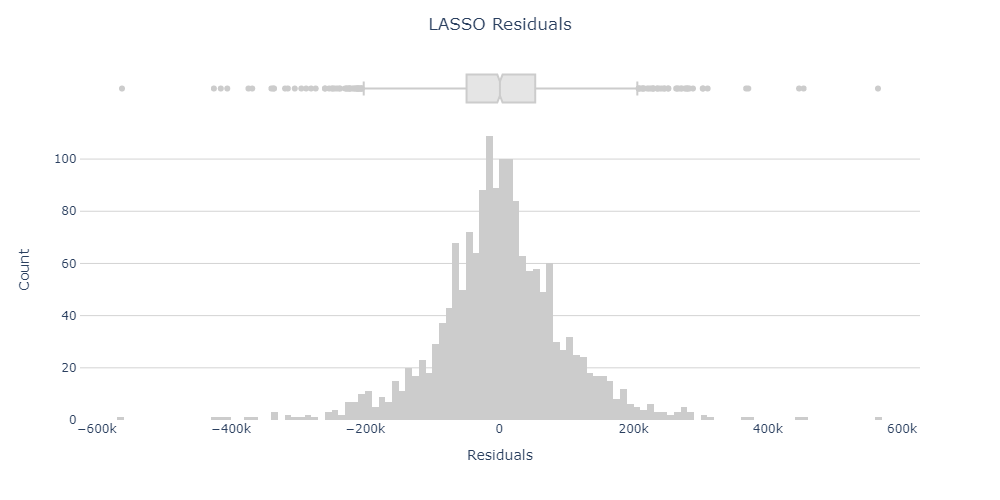

In [23]:
yhat = lasso.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                data, 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])


#Plot
fig = px.histogram(
                results, 
                x="residual",
                marginal="box",
                width=1000)

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
                title='LASSO Residuals', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Residuals",
                row=1, col=1)

fig.show()

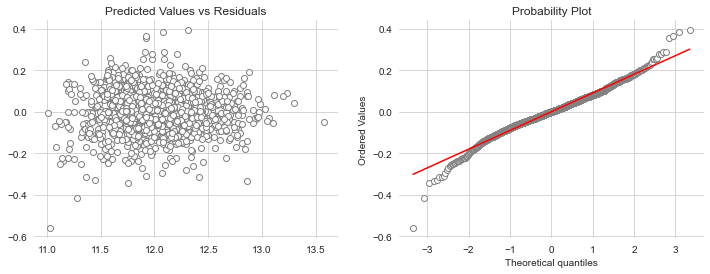

In [24]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)

ax[0].scatter(yhat, residuals, edgecolors='grey', color='white')
ax[0].title.set_text('Predicted Values vs Residuals')

stats.probplot(residuals, dist="norm", plot=plt)
ax[1].get_lines()[0].set_markeredgecolor('grey')
ax[1].get_lines()[0].set_markerfacecolor('white')

plt.show()

In [25]:
res = stats.shapiro(residuals)
res.statistic

0.9801800847053528

## Ridge

In [26]:
ridge = RidgeCV(cv=5)
ridge.fit(X_train_scaled, y_train)

best_alpha = ridge.alpha_
print('Best alpha:', best_alpha)

# Predict on the test set
y_pred = ridge.predict(X_test_scaled)

# Calculate RMSE
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse_ridge)


Best alpha: 10.0
RMSE: 0.09701535820304236


In [27]:
kf = KFold(n_splits=5, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(ridge, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(ridge, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(ridge, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.9277 0.9278 0.9341 0.9334 0.949 ]
Mean shuffled cross validation score: 0.9344
RMSE Shuffled cross validation score: [0.0946 0.0994 0.09   0.0967 0.0828]
RMSE Mean shuffled cross validation score: 0.0927


In [28]:
yhat_train = ridge.predict(X_train_scaled)
yhat_test = ridge.predict(X_test_scaled)

train_rmse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

16404.58520804157
16897.747851629087


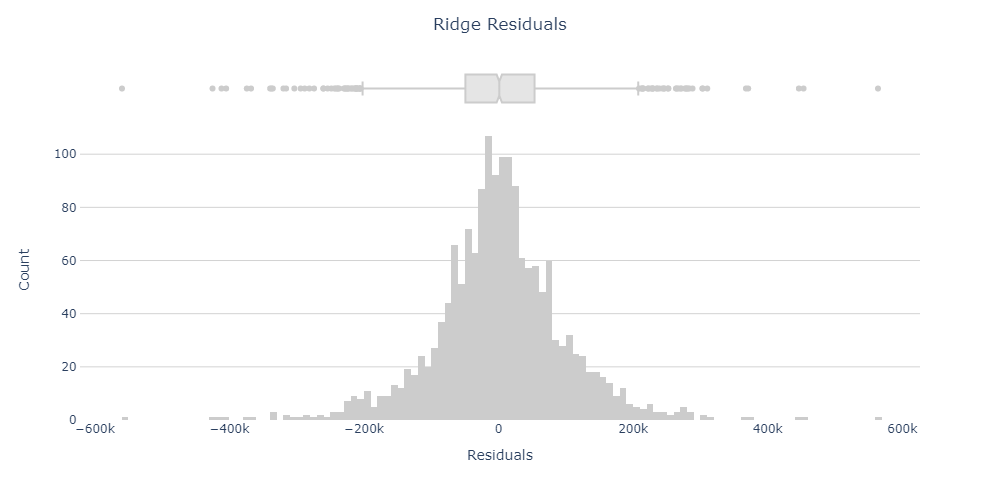

In [29]:
yhat = ridge.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                data, 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])


#Plot
fig = px.histogram(
                results, 
                x="residual",
                marginal="box",
                width=1000)

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
                title='Ridge Residuals', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Residuals",
                row=1, col=1)

fig.show()

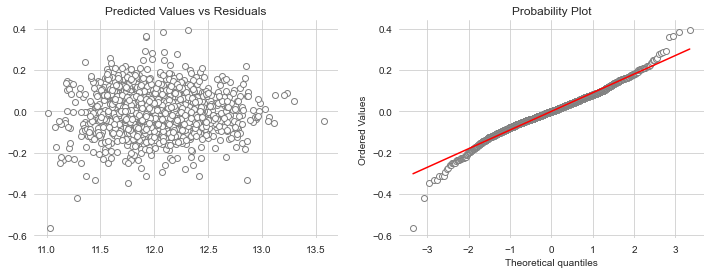

In [30]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)

ax[0].scatter(yhat, residuals, edgecolors='grey', color='white')
ax[0].title.set_text('Predicted Values vs Residuals')

stats.probplot(residuals, dist="norm", plot=plt)
ax[1].get_lines()[0].set_markeredgecolor('grey')
ax[1].get_lines()[0].set_markerfacecolor('white')

plt.show()

In [31]:
res = stats.shapiro(residuals)
res.statistic

0.9803360104560852

## Stats model

In [32]:
X_train_scaled_sm = sm.add_constant(X_train_scaled)

model = sm.OLS.from_formula('SalePrice ~  BsmtQual + OverallQual +\
                    GrLivArea + TotalBsmtSF  + GarageArea + FullBath + FlrSF1st + FlrSF2nd +\
                    HouseAge  + OverallCond + CentralAir +\
                    Fireplaces + LotArea + Remod +\
                    BsmtUnfSF + Zone + Location_2 + Location_3 + Location_4 +\
                    RemodAge + ExBsmtQual + RoadRail + KitchenQual + BedroomPerSF +\
                    GrLivArea:Fireplaces', 
                    data=pd.concat([X_train_scaled_sm, y_train], axis=1))

results_fu = model.fit()

n = X_train.shape[0]
results_fr = model.fit_regularized(L1_wt=0, alpha=1.1/n, start_params=results_fu.params)

#test_params = np.insert(ridge.coef_, 0, ridge.intercept_, axis=0)
test_params = np.round(results_fr.params, 6)
test_params[0] = results_fu.params[0]

final = sm.regression.linear_model.OLSResults(model, 
                                              test_params,
                                              model.normalized_cov_params)

final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     982.3
Date:                Tue, 08 Aug 2023   Prob (F-statistic):               0.00
Time:                        04:18:26   Log-Likelihood:                 1637.3
No. Observations:                1678   AIC:                            -3223.
Df Residuals:                    1652   BIC:                            -3082.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               12.0172      0.002   4869.256      0.000      12.012      12.022
BsmtQual                 0.0063      0.004      1.477      0.140      -0.002       0.015
OverallQual              0.0845      0.004     20.729      0.000       0.077       0.093
GrLivArea                0.0703      0.024      2.888      0.004       0.023       0.118
TotalBsmtSF              0.0699      0.005     14.301      0.000       0.060       0.079
GarageArea               0.0257      0.003      8.651      0.000       0.020       0.031
FullBath                -0.0033      0.003     -0.960      0.337      -0.010       0.003
FlrSF1st                 0.0336      0.019      1.779      0.075      -0.003       0.071
FlrSF2nd                 0.0469      0.022      2.157      0.031       0.004       0.090
HouseAge                -0.0513      0.005    -10.080      0.000      -0.061      -0.041
OverallCond              0.0513      0.003     17.147      0.000       0.045       0.057
CentralAir               0.0189      0.003      7.334      0.000       0.014       0.024
Fireplaces               0.0231      0.003      8.400      0.000       0.018       0.028
LotArea                  0.0462      0.003     15.238      0.000       0.040       0.052
Remod                   -0.0043      0.003     -1.478      0.140      -0.010       0.001
BsmtUnfSF               -0.0377      0.003    -14.024      0.000      -0.043      -0.032
Zone                     0.0131      0.003      3.996      0.000       0.007       0.020
Location_2               0.0058      0.004      1.431      0.153      -0.002       0.014
Location_3               0.0300      0.004      7.338      0.000       0.022       0.038
Location_4               0.0414      0.004      9.270      0.000       0.033       0.050
RemodAge                -0.0164      0.004     -4.500      0.000      -0.023      -0.009
ExBsmtQual               0.0123      0.003      4.094      0.000       0.006       0.018
RoadRail                -0.0109      0.002     -4.730      0.000      -0.015      -0.006
KitchenQual              0.0191      0.003      5.870      0.000       0.013       0.025
BedroomPerSF            -0.0120      0.003     -3.676      0.000      -0.018      -0.006
GrLivArea:Fireplaces    -0.0035      0.002     -1.498      0.134      -0.008       0.001
==============================================================================
Omnibus:                       94.693   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              317.652
Skew:                          -0.181   Prob(JB):                     1.05e-69
Kurtosis:                       5.100   Cond. No.                         43.6
==============================================================================

Notes:
[1] Standard Errors 

In [33]:
yhat_train = final.predict(X_train_scaled)
yhat_test = final.predict(X_test_scaled)

train_rmse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

16453.809411427297
17031.276833351505


In [34]:
yhat_train = final.predict(X_train_scaled)
yhat_test = final.predict(X_test_scaled)

train_rmse_non_log = mean_squared_error(y_train, yhat_train, squared=False)
test_rmse_non_log = mean_squared_error(y_test, yhat_test, squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

0.09119935062899068
0.09727578193857879


## Interactions with Location

In [35]:
data = df_engineered(df, Reg=False)

In [36]:
temp = data[data.Location==4]
#temp = data[data.LargerHouse==0]

X_train_loc, X_test_loc, y_train_loc, y_test_loc = \
    train_test_split(temp.drop(columns='SalePrice'), temp[['SalePrice']], test_size=0.30, random_state=42)

### Standardization

In [37]:
feature_selection = ['BsmtQual' , 'OverallQual' ,
                    'GrLivArea' , 'TotalBsmtSF'  , 'GarageArea', 'FullBath' ,'FlrSF1st' , 'FlrSF2nd',
                    'HouseAge'  , 'OverallCond' , 'TotRmsAbvGrd' , 'CentralAir',
                    'Fireplaces' , 'LotArea' , 'MSSubClass' ,
                    'BsmtUnfSF' , 'Zone' , 'Location',
                    'RemodAge' , 'ExBsmtQual' , 'RoadRail', 'KitchenQual' , 'HalfBath', 
                    'BsmtFinSF1', 'BedroomPerSF']

In [38]:
scaler = StandardScaler()

X_train_loc = X_train_loc.reset_index(drop=True)
X_test_loc = X_test_loc.reset_index(drop=True)

y_train_loc = np.log(y_train_loc.reset_index(drop=True)['SalePrice'])
y_test_loc = np.log(y_test_loc.reset_index(drop=True)['SalePrice'])

X_train_scaled_loc = pd.DataFrame(scaler.fit_transform(X_train_loc[feature_selection]), columns=X_train_loc[feature_selection].columns)
X_test_scaled_loc = pd.DataFrame(scaler.transform(X_test_loc[feature_selection]), columns=X_test_loc[feature_selection].columns)

In [39]:
X_train_scaled_sm = sm.add_constant(X_train_scaled_loc)

model = sm.OLS.from_formula('SalePrice ~  BsmtQual + OverallQual +\
                        GrLivArea + TotalBsmtSF  + GarageArea + FullBath + FlrSF1st + FlrSF2nd +\
                        HouseAge  + OverallCond + TotRmsAbvGrd + CentralAir +\
                        Fireplaces + LotArea + MSSubClass +\
                        BsmtUnfSF + Zone + Location +\
                        RemodAge + ExBsmtQual + RoadRail + KitchenQual + HalfBath + BedroomPerSF +\
                        BsmtFinSF1 +\
                        GrLivArea:Fireplaces', 
                    data=pd.concat([X_train_scaled_sm, y_train_loc], axis=1))

results_fu = model.fit()

n = X_train.shape[0]
results_fr = model.fit_regularized(L1_wt=0, alpha=0/n, start_params=results_fu.params)

#test_params = np.insert(ridge.coef_, 0, ridge.intercept_, axis=0)
test_params = np.round(results_fr.params, 6)
test_params[0] = results_fu.params[0]

final = sm.regression.linear_model.OLSResults(model, 
                                              test_params,
                                              model.normalized_cov_params)

final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     148.1
Date:                Tue, 08 Aug 2023   Prob (F-statistic):          8.78e-133
Time:                        04:18:27   Log-Likelihood:                 309.32
No. Observations:                 274   AIC:                            -568.6
Df Residuals:                     249   BIC:                            -478.3
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               12.4715      0.006   2262.008      0.000      12.461      12.482
BsmtQual                -0.0221      0.024     -0.928      0.354      -0.069       0.025
OverallQual              0.0681      0.009      7.836      0.000       0.051       0.085
GrLivArea               -0.5205      0.328     -1.588      0.114      -1.166       0.125
TotalBsmtSF              0.0476      0.019      2.443      0.015       0.009       0.086
GarageArea               0.0107      0.008      1.398      0.163      -0.004       0.026
FullBath                -0.0025      0.009     -0.290      0.772      -0.020       0.014
FlrSF1st                 0.5826      0.270      2.155      0.032       0.050       1.115
FlrSF2nd                 0.6852      0.332      2.065      0.040       0.032       1.339
HouseAge                -0.0497      0.022     -2.277      0.024      -0.093      -0.007
OverallCond              0.0211      0.010      2.159      0.032       0.002       0.040
TotRmsAbvGrd            -0.0169      0.011     -1.517      0.131      -0.039       0.005
CentralAir           -4.586e+13   1.72e-16  -2.66e+29      0.000   -4.59e+13   -4.59e+13
Fireplaces               0.0237      0.007      3.459      0.001       0.010       0.037
LotArea                  0.0274      0.006      4.329      0.000       0.015       0.040
MSSubClass              -0.0404      0.008     -5.090      0.000      -0.056      -0.025
BsmtUnfSF               -0.0487      0.013     -3.674      0.000      -0.075      -0.023
Zone                    -0.0212      0.005     -4.121      0.000      -0.031      -0.011
Location             -4.805e+13   2.84e-16  -1.69e+29      0.000    -4.8e+13    -4.8e+13
RemodAge                -0.0190      0.017     -1.128      0.260      -0.052       0.014
ExBsmtQual               0.0317      0.022      1.438      0.152      -0.012       0.075
RoadRail                 0.0046      0.005      0.902      0.368      -0.005       0.015
KitchenQual              0.0197      0.008      2.610      0.010       0.005       0.035
HalfBath                 0.0168      0.010      1.615      0.108      -0.004       0.037
BedroomPerSF            -0.0165      0.010     -1.586      0.114      -0.037       0.004
BsmtFinSF1               0.0012      0.015      0.080      0.936      -0.028       0.030
GrLivArea:Fireplaces    -0.0081      0.005     -1.493      0.137      -0.019       0.003
==============================================================================
Omnibus:                        1.460   Durbin-Watson:                   1.790
Prob(Omnibus):                  0.482   Jarque-Bera (JB):                1.230
Skew:                          -0.006   Prob(JB):                        0.541
Kurtosis:                       3.328   Cond. No.                     1.51e+16
==================

In [40]:
yhat_train_loc = final.predict(X_train_scaled_loc)
yhat_test_loc = final.predict(X_test_scaled_loc)

train_rmse_non_log = mean_squared_error(np.exp(y_train_loc), np.exp(yhat_train_loc), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(y_test_loc), np.exp(yhat_test_loc), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

21421.44920405147
22020.33599256968


In [41]:
# import math

# unscaled_coef = final.params[1:]

# transformed_coef = []
# for i in unscaled_coef:
#     j = math.exp(i)
#     transformed_coef.append(j)

In [42]:
# coef_effect = [(i - 1)*df.SalePrice.mean() for i in transformed_coef]

# var_impact = pd.DataFrame(data=[X_train_scaled_loc.columns, coef_effect]).T
# var_impact.columns = ["variable", "1-unit change"]
# var_impact

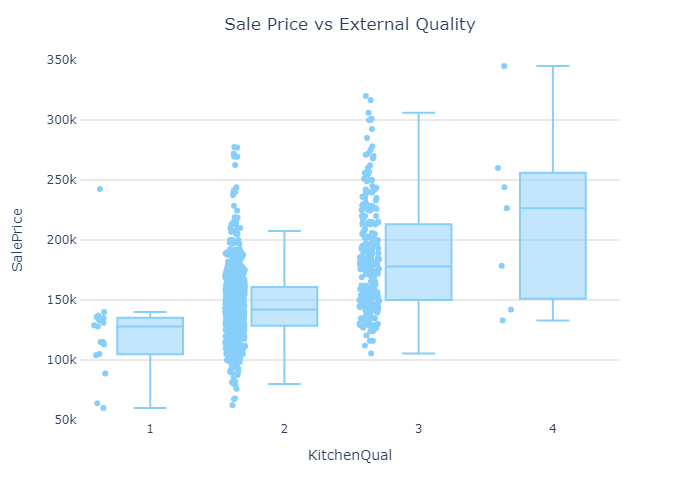

In [43]:
fig = px.box(
            data[data.Location==2], 
            x='KitchenQual', 
            y="SalePrice", 
            points="all")

fig.update_traces(marker_color = '#87CEFA')

fig.update_layout(title='Sale Price vs External Quality', title_x=0.5, showlegend=False, plot_bgcolor='white')

fig.update_xaxes(showline=False, gridcolor='white')
fig.update_yaxes(showline=True, gridcolor='lightgray', range=[50000,350000])

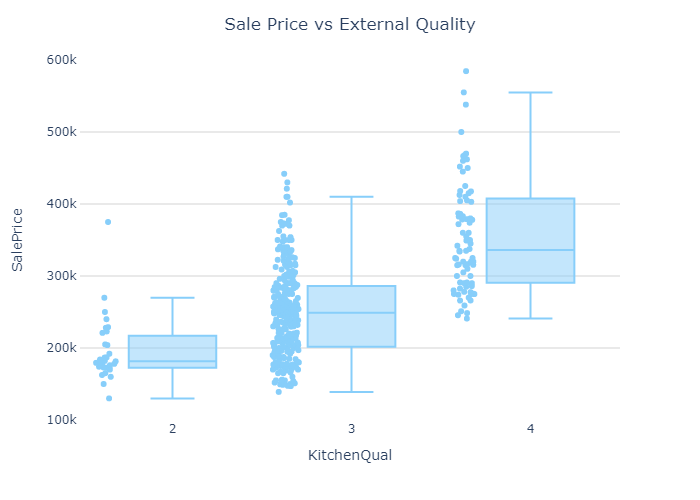

In [44]:
fig = px.box(
            data[data.Location==4], 
            x='KitchenQual', 
            y="SalePrice", 
            points="all")

fig.update_traces(marker_color = '#87CEFA')

fig.update_layout(title='Sale Price vs External Quality', title_x=0.5, showlegend=False, plot_bgcolor='white')

fig.update_xaxes(showline=False, gridcolor='white')
fig.update_yaxes(showline=True, gridcolor='lightgray', range=[100000,600000])

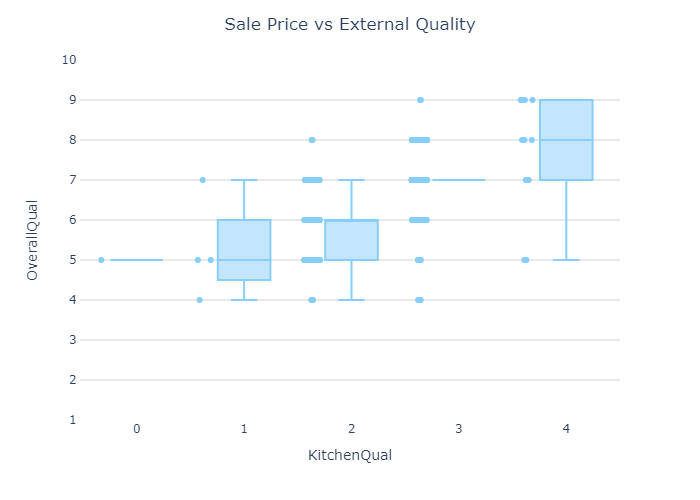

In [45]:
fig = px.box(
            data[data.Location==3], 
            x='KitchenQual', 
            y="OverallQual", 
            points="all")

fig.update_traces(marker_color = '#87CEFA')

fig.update_layout(title='Sale Price vs External Quality', title_x=0.5, showlegend=False, plot_bgcolor='white')

fig.update_xaxes(showline=False, gridcolor='white')
fig.update_yaxes(showline=True, gridcolor='lightgray', range=[1,10])

In [49]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

for location in (1,2,3,4):

    temp = data[data.Location==location]

    X_train_loc, X_test_loc, y_train_loc, y_test_loc = train_test_split(temp, temp[['SalePrice']], test_size=0.30, random_state=42)


    scaler = StandardScaler()

    X_train_loc = X_train_loc.reset_index(drop=True)
    X_test_loc = X_test_loc.reset_index(drop=True)

    y_train_loc = np.log(y_train_loc.reset_index(drop=True)['SalePrice'])
    y_test_loc = np.log(y_test_loc.reset_index(drop=True)['SalePrice'])

    X_train_scaled_loc = pd.DataFrame(scaler.fit_transform(X_train_loc[feature_selection]), columns=X_train_loc[feature_selection].columns)
    X_test_scaled_loc = pd.DataFrame(scaler.transform(X_test_loc[feature_selection]), columns=X_test_loc[feature_selection].columns)
    X_train_scaled_sm = sm.add_constant(X_train_scaled_loc)

    model = sm.OLS.from_formula('SalePrice ~  BsmtQual + OverallQual +\
                        GrLivArea + TotalBsmtSF  + GarageArea + FullBath + FlrSF1st + FlrSF2nd +\
                        HouseAge  + OverallCond + TotRmsAbvGrd + CentralAir +\
                        Fireplaces + LotArea + MSSubClass +\
                        BsmtUnfSF + Zone + Location +\
                        RemodAge + ExBsmtQual + RoadRail + KitchenQual + HalfBath + BedroomPerSF +\
                        BsmtFinSF1 +\
                        GrLivArea:Fireplaces', 
                        data=pd.concat([X_train_scaled_sm, y_train_loc], axis=1))

    results_fu = model.fit()

    n = X_train.shape[0]

    if location == 4:
        alpha = 0
    else:
        alpha=0.1
    results_fr = model.fit_regularized(L1_wt=0, alpha=alpha/n, start_params=results_fu.params)

    test_params = np.round(results_fr.params, 6)
    test_params[0] = results_fu.params[0]

    final = sm.regression.linear_model.OLSResults(model, 
                                                test_params,
                                                model.normalized_cov_params)

    final.summary()
    yhat_train_loc = final.predict(X_train_scaled_loc)
    yhat_test_loc = final.predict(X_test_scaled_loc)

    train_rmse_non_log = mean_squared_error(np.exp(y_train_loc), np.exp(yhat_train_loc), squared=False)
    test_rmse_non_log = mean_squared_error(np.exp(y_test_loc), np.exp(yhat_test_loc), squared=False)

    print(train_rmse_non_log)
    print(test_rmse_non_log)


    df_train_loc = pd.DataFrame(np.concatenate((np.array(yhat_train_loc).reshape(-1,1), np.array(y_train_loc).reshape(-1,1)), axis=1), 
                columns=['yhat_train', 'y_train'])
    df_train = pd.concat([df_train, df_train_loc], axis=0)

    df_test_loc = pd.DataFrame(np.concatenate((np.array(yhat_test_loc).reshape(-1,1), np.array(y_test_loc).reshape(-1,1)), axis=1), 
                columns=['yhat_train', 'y_train'])
    df_test = pd.concat([df_test, df_test_loc], axis=0)

14980.076713017788
17810.5377327288
12312.8051423977
13916.817571439497
14312.676081178186
15136.897593138556
21421.44920405147
22020.33599256968


In [50]:
train_rmse_non_log = mean_squared_error(np.exp(df_train.y_train), np.exp(df_train.yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(df_test.y_train), np.exp(df_test.yhat_train), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

15189.536100271416
16697.08528106928


In [52]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

for largerhouse in (0,1):

    temp = data[data.LargerHouse==largerhouse]

    X_train_loc, X_test_loc, y_train_loc, y_test_loc = train_test_split(temp, temp[['SalePrice']], test_size=0.30, random_state=42)


    scaler = StandardScaler()

    X_train_loc = X_train_loc.reset_index(drop=True)
    X_test_loc = X_test_loc.reset_index(drop=True)

    y_train_loc = np.log(y_train_loc.reset_index(drop=True)['SalePrice'])
    y_test_loc = np.log(y_test_loc.reset_index(drop=True)['SalePrice'])

    X_train_scaled_loc = pd.DataFrame(scaler.fit_transform(X_train_loc[feature_selection]), columns=X_train_loc[feature_selection].columns)
    X_test_scaled_loc = pd.DataFrame(scaler.transform(X_test_loc[feature_selection]), columns=X_test_loc[feature_selection].columns)
    X_train_scaled_sm = sm.add_constant(X_train_scaled_loc)

    model = sm.OLS.from_formula('SalePrice ~  BsmtQual + OverallQual +\
                        GrLivArea + TotalBsmtSF  + GarageArea + FullBath + FlrSF1st + FlrSF2nd +\
                        HouseAge  + OverallCond + TotRmsAbvGrd + CentralAir +\
                        Fireplaces + LotArea + MSSubClass +\
                        BsmtUnfSF + Zone + Location +\
                        RemodAge + ExBsmtQual + RoadRail + KitchenQual + HalfBath + BedroomPerSF +\
                        BsmtFinSF1 +\
                        GrLivArea:Fireplaces', 
                        data=pd.concat([X_train_scaled_sm, y_train_loc], axis=1))

    results_fu = model.fit()

    n = X_train.shape[0]
    results_fr = model.fit_regularized(L1_wt=0, alpha=1.1/n, start_params=results_fu.params)

    test_params = np.round(results_fr.params, 6)
    test_params[0] = results_fu.params[0]

    final = sm.regression.linear_model.OLSResults(model, 
                                                test_params,
                                                model.normalized_cov_params)

    final.summary()
    yhat_train_loc = final.predict(X_train_scaled_loc)
    yhat_test_loc = final.predict(X_test_scaled_loc)

    train_rmse_non_log = mean_squared_error(np.exp(y_train_loc), np.exp(yhat_train_loc), squared=False)
    test_rmse_non_log = mean_squared_error(np.exp(y_test_loc), np.exp(yhat_test_loc), squared=False)

    print(train_rmse_non_log)
    print(test_rmse_non_log)


    df_train_loc = pd.DataFrame(np.concatenate((np.array(yhat_train_loc).reshape(-1,1), np.array(y_train_loc).reshape(-1,1)), axis=1), 
                columns=['yhat_train', 'y_train'])
    df_train = pd.concat([df_train, df_train_loc], axis=0)

    df_test_loc = pd.DataFrame(np.concatenate((np.array(yhat_test_loc).reshape(-1,1), np.array(y_test_loc).reshape(-1,1)), axis=1), 
                columns=['yhat_train', 'y_train'])
    df_test = pd.concat([df_test, df_test_loc], axis=0)

11842.719617075218
12729.816080674635
21367.3834853014
20671.135726965524


In [53]:
train_rmse_non_log = mean_squared_error(np.exp(df_train.y_train), np.exp(df_train.yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(df_test.y_train), np.exp(df_test.yhat_train), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

16865.88302522166
16819.133481739107
